### Anaphora resolution

1) Get the pretrained model of FastText from https://fasttext.cc/docs/en/english-vectors.html

2) At the pytorch develop a model, that is a feed forward neural network that consists of three layers, an input layer of size 600, a first layer of size 300, a second layer of 80 and an output layer with two units, all layers have regularization and dropout. The activation function on all layers is ReLU

![scheme.jpg](attachment:scheme.jpg)

In [0]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df_dev = pd.read_csv('/content/drive/My Drive/gap-development.tsv',sep='\t')

The task is to identify the target of a pronoun within a text passage. The source text is taken from Wikipedia articles. In the dataset, there are labels of the pronoun and two candidate names to which the pronoun could refer. An algorithm should be capable of deciding whether the pronoun refers to name A, name B, or neither.  
There are the following columns for analysis:
* ID - Unique identifier for an example (Matches to Id in output file format);
* Text - Text containing the ambiguous pronoun and two candidate names (about a paragraph in length);
* Text - Text containing the ambiguous pronoun and two candidate names (about a paragraph in length);
* Pronoun - The target pronoun (text);
* Pronoun-offset The character offset of Pronoun in Text;
* A - The first name candidate (text);
* A-offset - The character offset of name A in Text;
* B - The second name candidate;
* B-offset - The character offset of name B in Text;
* URL - The URL of the source Wikipedia page for the example;


In [4]:
df_dev.head()

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
0,development-1,Zoe Telford -- played the police officer girlf...,her,274,Cheryl Cassidy,191,True,Pauline,207,False,http://en.wikipedia.org/wiki/List_of_Teachers_...
1,development-2,"He grew up in Evanston, Illinois the second ol...",His,284,MacKenzie,228,True,Bernard Leach,251,False,http://en.wikipedia.org/wiki/Warren_MacKenzie
2,development-3,"He had been reelected to Congress, but resigne...",his,265,Angeloz,173,False,De la Sota,246,True,http://en.wikipedia.org/wiki/Jos%C3%A9_Manuel_...
3,development-4,The current members of Crime have also perform...,his,321,Hell,174,False,Henry Rosenthal,336,True,http://en.wikipedia.org/wiki/Crime_(band)
4,development-5,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,Kitty Oppenheimer,219,False,Rivera,294,True,http://en.wikipedia.org/wiki/Jessica_Rivera


In [5]:
df_dev.iloc[0]['Text']

"Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline."

In [6]:
df_dev.iloc[0]['Pronoun']

'her'

In [0]:
df_val = pd.read_csv('/content/drive/My Drive/gap-validation.tsv',sep='\t')

In [8]:
df_val.head()

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
0,validation-1,He admitted making four trips to China and pla...,him,256,Jose de Venecia Jr,208,False,Abalos,241,False,http://en.wikipedia.org/wiki/Commission_on_Ele...
1,validation-2,"Kathleen Nott was born in Camberwell, London. ...",She,185,Ellen,110,False,Kathleen,150,True,http://en.wikipedia.org/wiki/Kathleen_Nott
2,validation-3,"When she returns to her hotel room, a Liberian...",his,435,Jason Scott Lee,383,False,Danny,406,True,http://en.wikipedia.org/wiki/Hawaii_Five-0_(20...
3,validation-4,"On 19 March 2007, during a campaign appearance...",he,333,Reucassel,300,True,Debnam,325,False,http://en.wikipedia.org/wiki/Craig_Reucassel
4,validation-5,"By this time, Karen Blixen had separated from ...",she,427,Finch Hatton,290,False,Beryl Markham,328,True,http://en.wikipedia.org/wiki/Denys_Finch_Hatton


In [0]:
### Put your code here

from torch import nn
import numpy as np
from gensim.models.fasttext import FastText as FT_gensim
fasttext = FT_gensim.load_fasttext_format('/content/drive/My Drive/wiki.en.bin')

In [10]:
import torch
train_data_X = []
for i in range(len(df_dev['Text'])):
    temp1 = np.append(fasttext.wv[df_dev['Text'][i]],fasttext.wv[df_dev['Pronoun'][i]])
    temp2 = np.append(temp1, fasttext.wv[df_dev['A'][i]])
    to_train = np.append(temp2, fasttext.wv[df_dev['B'][i]])
    train_data_X.append(to_train)
X = torch.tensor(train_data_X).float()
print('train_data_X size: ', len(X[0]))

train_data_y = []
y1 = df_dev['A-coref'].replace(True,1)
y2 = df_dev['B-coref'].replace(True,1)
for i in range(len(X)):
    temp = np.append(y1[i],y2[i])
    train_data_y.append(temp)
Y = torch.tensor(train_data_y).float()
print('train_data_Y size: ', len(Y[0]))

train_data_X size:  1200
train_data_Y size:  2


In [0]:
class myNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(myNN, self).__init__()
        self.classificator = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(p = 0.3),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(p = 0.3),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Dropout(p = 0.3),
            nn.Linear(hidden_sizes[2], output_size)
        )
    def forward(self, x):
        output = self.classificator(x)
        return output

In [12]:
input_size = len(X[0])
hidden_sizes = [600,300, 80]
output_size = 2

model = myNN(input_size, hidden_sizes, output_size)
loss_fn = torch.nn.SmoothL1Loss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_arr = []
num_epochs = 5000
for i in range(num_epochs):
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = loss_fn(Y_pred, Y)
    loss_arr.append(loss)
    if (i%100 == 0):
        print(i, loss.item())
    loss.backward()
    optimizer.step()

0 0.2229291796684265
100 0.10748165845870972
200 0.033215489238500595
300 0.01558914314955473
400 0.011182235553860664
500 0.008277066051959991
600 0.007584089878946543
700 0.007566582877188921
800 0.006402725353837013
900 0.005981431808322668
1000 0.005745122209191322
1100 0.005393362604081631
1200 0.005227705929428339
1300 0.005042365752160549
1400 0.004929412622004747
1500 0.004497047048062086
1600 0.004479686263948679
1700 0.004173140972852707
1800 0.004321929533034563
1900 0.00401674909517169
2000 0.004123984836041927
2100 0.003990926314145327
2200 0.003909176215529442
2300 0.0037602342199534178
2400 0.0037679080851376057
2500 0.00379855465143919
2600 0.0035868908744305372
2700 0.003360231639817357
2800 0.0034095770679414272
2900 0.003370582824572921
3000 0.0034072112757712603
3100 0.003126344410702586
3200 0.003177874954417348
3300 0.003011175896972418
3400 0.0030276658944785595
3500 0.0030500278808176517
3600 0.0029946202412247658
3700 0.002961772261187434
3800 0.002811200683936

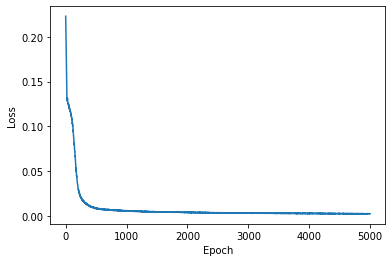

In [13]:
import matplotlib.pyplot as plt
epoch = []
for i in range (len(loss_arr)):
    epoch.append(i)
plt.plot(epoch, loss_arr)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [15]:
val_data_length = len(df_val['Text'])
test_data_X = []
for i in range(val_data_length):
    temp1 = np.append(fasttext.wv[df_val['Text'][i]], fasttext.wv[df_val['Pronoun'][i]])
    temp2 = np.append(temp1, fasttext.wv[df_val['A'][i]])
    to_test = np.append(temp2, fasttext.wv[df_val['B'][i]])
    test_data_X.append(to_test)
X_test = torch.tensor(test_data_X).float()
print('test_data_X size: ', len(X_test[0]))

test_data_y = []
y1 = (df_val['A-coref'].replace(True, 1).values)
y2 = (df_val['B-coref'].replace(True, 1).values)
for i in range(val_data_length):
    temp = np.append(y1[i],y2[i])
    test_data_y.append(temp)
Y_test = torch.tensor(test_data_y).float()
print('test_data_Y size: ', len(Y_test[0]))

test_data_X size:  1200
test_data_Y size:  2


In [0]:
y_test_pred = model(X_test)
#y_test_pred_np = y_test_pred.detach().numpy()
y_test_pred_np = (np.round((y_test_pred).detach().numpy() ))**2

In [17]:
y_test_pred_np

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.

In [0]:
y_test_class = []
for i in range (len(Y_test)):
    y_test2 = Y_test[i].detach().numpy()
    if (y_test2[0] == 0):
        if (y_test2[1] == 0):
            y_test_class.append('false-negative')
    if (y_test2[0] == 0):
        if (y_test2[1] == 1):
            y_test_class.append('false-positive')
    if (y_test2[0]== 1):
        if (y_test2[1]== 0):
            y_test_class.append('true-negative')
    if (y_test2[0]== 1):
        if (y_test2[1] == 1):
            y_test_class.append('true-positive')

In [0]:
y_test_pred_class = []
for i in range (len(y_test_pred_np)):
    y_test2 = y_test_pred_np[i]
    if (y_test2[0] == 0):
        if (y_test2[1] == 0):
            y_test_pred_class.append('false-negative')
    if (y_test2[0] ==0):
        if (y_test2[1] == 1):
            y_test_pred_class.append('false-positive')
    if (y_test2[0] == 1):
        if (y_test2[1] == 0):
            y_test_pred_class.append('true-negative')
    if (y_test2[0] == 1):
        if (y_test2[1] == 1):
            y_test_pred_class.append('true-positive')

In [20]:
from sklearn.metrics import classification_report
clr = classification_report(y_test_class, y_test_pred_class)
print(clr)

                precision    recall  f1-score   support

false-negative       0.24      0.20      0.22        65
false-positive       0.53      0.59      0.56       205
 true-negative       0.51      0.46      0.48       184
 true-positive       0.00      0.00      0.00         0

      accuracy                           0.48       454
     macro avg       0.32      0.31      0.31       454
  weighted avg       0.48      0.48      0.48       454



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
y_test_np = np.array(Y_test)
model_was_right = 0
for i in range(len(y_test_np)):
    if (y_test_np[i][0] == y_test_pred_np[i][0]):
        if (y_test_np[i][1] == y_test_pred_np[i][1]):
            model_was_right = model_was_right + 1
accuracy = 100*model_was_right/(len(y_test_np))
print('Model was right in ', model_was_right, 'from ', len(y_test_np),' observations. So accuracy is ', round(accuracy, 2), '%')

Model was right in  219 from  454  observations. So accuracy is  48.24 %
